# Small-scale SWI
#### Saltwater intrusion model paired with AEM data acquisition for use with sensitivity analysis



In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
import scipy.stats as sts
import flopy
import SGD
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Name model
modelname = 'homogenous'
tot_it = 10



if sys.platform == "darwin":
    model_ws = Path('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work').joinpath(modelname)
elif sys.platform == "win32":
    model_ws = Path(r'E:\Projects\DelawareSGD\work').joinpath(modelname)
#     model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe #set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))


workdir = Path('../')
figdir=  workdir.joinpath('work','figs')
datadir = workdir.joinpath('data')
objdir =  workdir.joinpath('data','objs')

3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.3
flopy version: 3.2.10
Model workspace: /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous


In [3]:
# ### Utility functions
# 

# In[2]:

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple):
    import numpy as np
    point_list = []
    
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,m.ncol-1))
    point_list = tuple(np.array(point_list).T)
    return point_list

#create random clay blocks throughout model (quick dirty way to do heterogeneity)
def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]+sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks


def get_yn_response(prompt):
    while True:
        try:
            resp = str(input(prompt))
        except ValueError:
            print("Sorry, I didn't understand that.")
            continue
        if resp[0] is 'y':
            value = True
            break
        elif resp[0] is 'n':
            value = False
            break
        else:
            print('This didnt work right. Try again')
            continue
    return value

def get_value(prompt):
    while True:
        try:
            resp = str(input(prompt))
            break
        except ValueError:
            print("Sorry, I didn't understand that.")
            continue
    return resp

def check_MC_inputParams():
    if m.MC_file is not None:
        use_existing_MCfile = get_yn_response("m.MC_file already exists, continue using this experiment?")
    else:
        use_existing_MCfile = False
    if use_existing_MCfile:
        if m.inputParams is not None:
            if len(m.inputParams)>0:
                add_to_inputParams = get_yn_response("m.inputParams already has entries, do you want to add to it?")
            else:
                add_to_inputParams =False
            if add_to_inputParams:
                pass
            else: 
                m.inputParams = {}
        else:
            m.inputParams = {}
    else:
        load_existing_MCfile = get_yn_response("load MC file?")
        if load_existing_MCfile:
            f = get_value("path to MC_file (path/to/test.expt): ")
            m.inputParams = load_obj(Path(f),'inputParams')
            print('loaded .pkl file!')
        else:
            create_MC_file()
            m.inputParams = {}
    return

#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m

Lx = 3000.
Ly = 1000.
Lz = 80.

Lx = 3000.
Ly = 600.
Lz = 80.

xul=488930.5-3 #minimum x value - 3
yul=4271464.0-32 #minimum y value -32 to place in front of breakwater
rotation=0

henry_top = 3
ocean_elev = 0
delv_first = 5


botm_first = henry_top-delv_first

nlay = int(Lz*1/3)
nrow = int(Ly*(1/30))
ncol = int(Lx*(1/30))

delv = (Lz-delv_first) / (nlay-1)
delr = Lx / ncol
delc = Ly / nrow

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]

beachslope = .05

##dev
#Create ocean boundary at top of model
ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

inland_elev = beachslope*ocean_col[0]*delr
offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr

#beach_arr = matlib.repmat(np.linspace(inland_elev,offshore_elev,num=ncol),nrow,1)
#henry_top = ocean_elev*np.ones((nrow,ncol), dtype=np.float) + beach_arr
#henry_botm = matlib.repmat(np.linspace(ocean_elev - delv, ocean_elev - Lz, nlay),ncol,1).transpose() + beach_arr[1]
#henry_botm = np.transpose(np.tile(henry_botm,(nrow,1,1)),
#                          (1,0,2))
##dev


#Period data
Lt = 360*20 #Length of time in days
perlen = list(np.repeat(180,int(Lt/180)))
nstp = list(np.ones(np.shape(perlen),dtype=int))

nper = len(perlen)
steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.8
ssm_data = None
verbose = True


#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, xul=xul, yul=yul, rotation=rotation,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)

#Hydraulic conductivity field 
hkSand = 80.  #horizontal hydraulic conductivity m/day
hkClay = 1. 
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background
addclay_yn = 0

#add random low conductivity regions
if addclay_yn == 1:
    lithmat = rand_clay_blocks(lithmat,hkClay,100,(2,1,5))

#Set Hydraulic properties

hk = lithmat
sy = 0.15
ss = 0.00005
por = 0.2
vka = 1/10 # = vk/hk
al = 10 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day  from Walther et al. 2017

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density



# In[6]:

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                continue
    return new_weldata, new_ssmdata


#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,writeyn=0,model=None,varname=None,log_backtransf=0,*args):
    smp = distclass.rvs(*args,size=size)
    if log_backtransf==1:
        smp = tuple([10**x for x in smp])
    if size==1:
        smp=smp[-1]
    if writeyn==1:
        write_sample(model.MC_file,varname,distclass,smp)
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(str(fname),"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return


#BCs
bc_ocean = 'GHB'
bc_right_edge = 'GHB'
bc_inland = 'WEL'
add_wells = 1
n_wells = 2
rech_on = 1

#BC values 
#Inland
calc_inland_head = 0 #calculate from hgrad
#manual_inland_head = henry_top + .1
manual_inland_head = .75
#influx = hkSand*delr*delv*hgrad*nlay #m^3/day through inland boundary
influx = 1.41e-7 *Ly*Lz #from Walther et. al 2017
#influx = 0.015*(delc*nrow)*(delv*nlay)

start_fresh_yn = 1

ocean_shead = [ocean_elev for x in range(len(perlen))] 
ocean_ehead = ocean_shead

# save cell fluxes to unit 53
ipakcb = 53

#MODFLOW BCs
hgrad = 0.0033 #hydraulic gradient, m/m
qinflow = 0  #influent FW m3/day

#Create ocean boundary at top of model
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool


if calc_inland_head == 1:
    head_inland = ocean_col[0]*delc*hgrad + ocean_elev
else:
    head_inland = manual_inland_head

####IN TESTING#####
#Create a line of where the ocean is, and any nodes on right edge below ocean
offshore_lay = (np.abs(henry_botm-offshore_elev)).argmin().astype('int')
if ocean_col[0] == ncol-1:
    ocean_line = []
    bc_ocean = 'XXX'
else:
    ocean_line = get_line((0,ocean_col[0]),(offshore_lay,ocean_col[1]),allrows=1,nrow=1)

ocean_line_tuple = tuple(np.array(ocean_line).T) #use this for indexing numpy arrays
right_edge = get_ocean_right_edge(m,ocean_line_tuple)

#Create ibound
ibound,ocean_hf = shade_above(nlay,nrow,ncol,ocean_line) #don't set ibound of ocean
#ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
if bc_ocean == 'GHB':
    ibound[ocean_line_tuple]=1
#ibound[:, :, 0] = -1 #first column (FW boundary) has fixed head
#ibound[0:1,:,ocean_col[0]-3:ocean_col[0]] = 0 #small block before beach is no-flow

if bc_right_edge =='CHD':
    ibound[right_edge] = -1


#Set starting heads
strt = ocean_elev*np.ones((nlay, nrow, ncol),dtype='float') #starting heads

if bc_inland=='CHD':
    strt[:,:,0] = head_inland #head inland
if len(ocean_hf)>0:
    strt[ocean_hf[0],
        ocean_hf[1],
        ocean_hf[2]] = ocean_hf[3] #self-calculate equivalent FW head; this is repeated in CHD/GHB package
    right_edge_hf = ocean_hf[3][-1] - (densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)
else:
    right_edge_hf = -(densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)

strt[right_edge] = right_edge_hf
#strt[right_edge] = ocean_hf[3][-1] #set right (ocean) edge below the sloped boundary
#strt[ocean_hf[0][-1] +1:,:,-1] = ocean_hf[3][-1]
strt = np.zeros((nlay,nrow,ncol),dtype=np.int)


#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

if ocean_hf:
    sconc[ocean_hf[0:3]] = Csalt
sconc[:,:,-1] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
### If using SSM, I think we don't need to hold cells as constant concentration
#icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head
#icbund[:,:,0] = -1 #right now hold inland boundary to constant concentration
icbund[np.where(ibound==-1)] = -1

def make_bc_dicts():
    #Ocean and inland boundary types
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    chd_data = {}
    ssm_data = {}
    ghb_data = {}
    wel_data = {}
    for i in range(nper):
        dat_chd = []
        dat_ssm = []
        dat_ghb = []
        dat_wel = []
        #Ocean boundary
        if ocean_hf:
            for j in range(np.size(ocean_hf[0])):
                if bc_ocean=='CHD':
                    #CHD: {stress_period: [lay,row,col,starthead,endhead]}
                    dat_chd.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                ocean_shead[i],
                                ocean_ehead[i]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                Csalt,
                                itype['CHD']])
                elif bc_ocean=='GHB':
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    #conductance c = K*A/dL; assume horizontal flow at outlet,
                    #and calculate length to be at edge of ocean cell, as opposed to mipoint
                    # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                    dat_ghb.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   #ocean_hf[3][j],
                                    ocean_elev,
                                   2*hkSand*delc*delv_vec[ocean_hf[0][j]]/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   Csalt,
                                   itype['GHB']])
        else:
            pass
        #Right edge boundary
        if bc_right_edge=='GHB':
            for j in range(np.size(right_edge[0])):
                #GHB: {stress period: [lay,row,col,head level,conductance]}
                #conductance c = K*A/dL; assume horizontal flow at outlet,
                #and calculate length to be at edge of ocean cell, as opposed to mipoint
                # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                dat_ghb.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               #ocean_hf[3][j],
                                ocean_elev,
                               2*hkSand*delc*delv_vec[right_edge[0][j]]/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               Csalt,
                               itype['GHB']])
        else:
            pass
        #Inland boundary
        if bc_inland=='GHB':
            for j in range(nlay):
                for k in range(nrow):
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    dat_ghb.append([j,k,0,head_inland,
                                    2*hkSand*delc*delv_vec[j]/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['GHB']])
        elif bc_inland=='WEL':
            for j in range(nlay):
                for k in range(nrow):
                    #WEL: {stress_period: [lay,row,col,flux]}
                    dat_wel.append([j,k,0,influx*delv_weight[j]/nrow])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['WEL']])
        chd_data[i] = dat_chd
        ssm_data[i] = dat_ssm
        ghb_data[i] = dat_ghb
        wel_data[i] = dat_wel

    #saving concentrations at specified times
    #timprs = [k for k in range(1,np.sum(perlen),50)]
    return chd_data, ssm_data, ghb_data, wel_data

chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()
wel_data_base,ssm_data_base = wel_data,ssm_data
timprs = np.round(np.linspace(1,np.sum(perlen),20),decimals=0)

create_MC_file()
print('Created MC file in ',m.MC_file.parent)
save_obj(m.MC_file.parent,wel_data_base,'wel_data_base')
save_obj(m.MC_file.parent,ssm_data_base,'ssm_data_base')


#### ADD WELL AND RECHARRGE DATA####
#Winter is even stress periods, summer is odd SP.
#Winter= wells OFF, natural precip (rech) ON, irrigation rech OFF, 
#Summer = wells ON, irrigation rech (rech_farm) ON,  precip (rech) OFF 

##Add recharge data
rech = 1e-6

#Assign the location of the farms 
farm_leftmargin = 10
farm_uppermargin = 1
nfarms = 4
farm_size = (200,200) #m in row,col direction
farm_size_rowcol = (int(farm_size[0]/delc),int(farm_size[1]/delr)) #size of farm in number of row,col

farm_loc_r = []
farm_loc_c = []
farm_orig = []
for x in range(int(nfarms/2)):
    for y in range(2):
        for z1 in range(farm_size_rowcol[0]):
            for z2 in range(farm_size_rowcol[1]):
                farm_loc_r.append(farm_uppermargin + y*(farm_size_rowcol[0]+2) + z1)
                farm_loc_c.append(farm_leftmargin + x*(farm_size_rowcol[1]+2) + z2)
                if (z1==0) and (z2==0):
                    farm_orig.append((farm_loc_r[-1],farm_loc_c[-1])) #upper left of ea. farm=loc of well
farm_loc = (np.array(farm_loc_r),np.array(farm_loc_c))



## Add well data
n_wells = nfarms
kper_odd = list(np.arange(1,nper,2))
kper_even = list(np.arange(0,nper,2))
#wel_lowhigh = np.log10((1e0,1e2))
#wel_flux = sample_dist(sts.uniform,n_wells,0,m,'wel',1,*(wel_lowhigh[0],wel_lowhigh[1]-wel_lowhigh[0]))
wel_flux = [1e0,1e0,1e0,1e0]
wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,wel_flux,farm_orig,kper_odd)


## Add farm recharge data
#farm_rechargs = (rechargs[0],rechargs[1]) #note: this is in log space
#farm_rechargs = (int(wel_lowhigh[0]-1),int(wel_lowhigh[1]-1))
#farm_rech_flux = sample_dist(sts.uniform,1,0,m,'rech',1,*farm_rechargs)
farm_rech_flux = wel_flux[0]*0.1
rech_farm = np.zeros((nrow,ncol),dtype=np.float)
rech_farm[farm_loc] = farm_rech_flux/np.prod(farm_size)
#Set rech_data for winter and summer
rech_data = {}
for i in range(len(perlen)):
    if i%2==0:
        rech_data[i] = np.ones((nrow,ncol),dtype=np.float)*rech 
    else:
        rech_data[i] = rech_farm                            


riv_loc = get_line((0,0),(0,ncol-1),allrows=1,nrow=nrow)
riv_loc = [x for x in riv_loc if x[1]==int(nrow/2)] 
riv_loc = tuple(np.array(riv_loc).T)

riv_grad = .001
rbot_vec = np.linspace(riv_grad*Lx,ocean_elev,ncol)

#Stage and conductance:
stage = 1
cond = 10
riv_grad = .001

def write_river_data(riv_loc,stage,cond,riv_grad,kper,ssm_data):
    
    ####ADD RIVER DATA####
    rbot_vec = np.linspace(riv_grad*Lx,ocean_elev,ncol)

    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    riv_data = {}
    new_ssm_data = ssm_data
    for i in range(nper):
        dat_riv = []
        if i in kper:
            for j in range(np.size(riv_loc[0])):
                #RIV: {stress_period:[lay, row, col, stage, cond, rbot],...}
                dat_riv.append([riv_loc[0][j],
                                    riv_loc[1][j],
                                    riv_loc[2][j],
                                    stage+rbot_vec[riv_loc[2][j]],
                                    cond,
                                    rbot_vec[riv_loc[2][j]]])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                new_ssm_data[i].append([riv_loc[0][j],
                                        riv_loc[1][j],
                                        riv_loc[2][j],
                                        Cfresh,
                                        itype['RIV']])
        else:
            for j in range(np.size(riv_loc[0])):
                #RIV: {stress_period:[lay, row, col, stage, cond, rbot],...}
                dat_riv.append([riv_loc[0][j],
                                    riv_loc[1][j],
                                    riv_loc[2][j],
                                    rbot_vec[riv_loc[2][j]], #set stage as bottom of river
                                    cond,
                                    rbot_vec[riv_loc[2][j]]])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                new_ssm_data[i].append([riv_loc[0][j],
                                        riv_loc[1][j],
                                        riv_loc[2][j],
                                        Cfresh,
                                        itype['RIV']])
        riv_data[i] = dat_riv
    return riv_data,new_ssm_data

riv_data,ssm_data = write_river_data(riv_loc,stage,cond,riv_grad,kper_even,ssm_data)

# ### Notes on Farm fields
# North Marina Area: 
# Fields can be as close as 400m from the coast!! Others closer to 1.7km
# 
# Most fields are about 200x200m, some fields that appear to be row crops (strawberry? lettuce?) are 100x100 or so
# 
# Fields are in a 3 distinct patches, each patch is almost completely covered with crops:
# 
# -Near coast (400m+), verdant larger plots.
# 
# -1.7km inland, pale colored, tight rows
# 
# -2.75km inland, larger plots, varied color
# 
# 
# Salinas Valley:
# Most fields are about 200-250m wide minimum and can be 300-600m long

#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']


# In[13]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='CHD' or bc_inland=='CHD' :
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
rch = flopy.modflow.ModflowRch(m, rech=rech_data)
riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

printyn = 0
gridon=0
rowslice=riv_loc[1][0]
#rowslice = farm_orig[0][0]
#m.plot_hk_ibound(rowslice=rowslice,printyn=printyn,gridon=gridon);

#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass


# In[ ]:




# In[16]:

#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')

run_basemodel = get_yn_response("Run the base case model?")
if run_basemodel:
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])

print('MC file in \t',m.MC_file.parent)

homogenous.nam
adding Package:  DIS
/Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous/MC_expt_2020-01-27-07-07/expt.txt
Created MC file in  /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous/MC_expt_2020-01-27-07-07
adding Package:  BAS6
adding Package:  GHB
Adding homogenous.cbc (unit=53) to the output list.
adding Package:  WEL
adding Package:  RCH
adding Package:  RIV
adding Package:  LPF
adding Package:  PCG
Adding homogenous.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
found 'rch' in modflow model, resetting crch to 0.0
adding Package:  SSM
adding Package:  VDF

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  WEL
   Package:  RCH
Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_2: locat is None, but model does not support free format and how is inte

Run the base case model? n


MC file in 	 /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous/MC_expt_2020-01-27-07-07


In [134]:
# ## Post-processing results

# In[17]:

#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',per=-1,scale=50,rowslice=0):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[per]
    qz = budobj.get_data(text='FLOW LOWER FACE')[per]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, rowslice, ::iskip], -qz_avg[::iskip, rowslice, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection

def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique

def kstpkper_from_time(ucnobj,tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)    
    kstpkper = kstpkpers[timeind]
    return kstpkper

def kstpkper_ind_from_kstpkper(ucnobj,kstpkper=(0,0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind

def get_salt_outflow(m,kstpkper=None,totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    totim = ucnobj.get_times()[-1]
    if kstpkper==None:
        kstpkper = ucnobj.get_kstpkper()[-1]
    ocean_conc = ucnobj.get_data(kstpkper=kstpkper)
    return ocean_conc
    
def plot_background(mm,array,label=None):
    if label==None:
        label = [k for k,v in globals().items() if v is array][-1]
    if label=='hk':
        norm=matplotlib.colors.LogNorm()
        vmin=hkClay
        vmax=hkSand
        cmap='jet'
    else:
        norm = None
        vmin=None
        vmax=None
        cmap='jet'
    cpatchcollection = mm.plot_array(array,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    cpatchcollection.set_label(label)
    return cpatchcollection,label

def plot_mas(m):
    # Load the mas file and make a plot of total mass in aquifer versus time
    fname = os.path.join(m.model_ws, 'MT3D001.MAS')
    mas = flopy.mt3d.Mt3dms.load_mas(fname)
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('Time (d)')
    plt.ylabel('Mass (kg)')
    plt.title('Mass of salt within model through time')
    lines = ax.plot(mas.time, mas.total_mass)
    plt.show()
    return mas

### MC Experiment

#### Sample distributions

In [147]:
tot_it = 2
seed = 1
np.random.seed(seed)
varlist = {}

import scipy.stats as sts
from scipy.io import savemat

def add_to_paramdict(paramdict,paramname,val):
    if paramdict is None:
        paramdict = {}
    if  paramname in list(paramdict.keys()):
        paramdict[paramname].append(val)
    else:
        #paramdict.update(paramname=[val])
        paramdict[paramname] = [val]
    return


def record_salinity(m,totim=None,fname_write=None,ts_hms=None):
    from pathlib import Path
    if ts_hms is None:
        ts_hms = datetime.datetime.now().strftime('%H-%M-%S')
    # Extract final timestep salinity
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    if totim is None:
        totim = ucnobj.get_times()[-1]
    conc = ucnobj.get_data(totim=totim)
    if fname_write is None:
        fname_write = m.MC_file.parent.joinpath('conc_' + str(int(totim)) + '_' + ts_hms + '.npy')
        print(fname_write)
        np.save(fname_write,conc)
    return conc

def copy_rename(src_file, dst_file):
    import shutil
    from pathlib import Path
    shutil.copy(str(Path(src_file)),str(Path(dst_file)))
    return

def idx2centroid(node_coord_tuple,idx_tuple):
    z_pt = node_coord_tuple[2][idx_tuple]
    x_pt = node_coord_tuple[1][idx_tuple[2]]
    y_pt = node_coord_tuple[0][idx_tuple[1]]
    return (z_pt,y_pt,x_pt)
def sample_uniform(low,high,shape,logyn):
    '''
    #Samples a uniform distribution the nummber of times shown in 
    low: low value in dist
    high: high value in dist
    shape: shape of samples
    logyn: if True, samples as a log-normal distribution. 
        If False, samples as a uniform distribution. Returned values are *not* in logspace  
    '''
    
    if logyn:
        log_param_list = np.random.uniform(np.log(low),np.log(high),shape)
        param_list = np.exp(log_param_list)
    else:
        param_list = np.random.uniform(low,high,shape)
    return param_list

#log_hk
logyn=True
low= 10
high = 100
varlist['hk']=sample_uniform(low,high,tot_it,logyn)

#vka: ratio of vk/hk
logyn=False
low= 1/20
high = 1
varlist['vka']=sample_uniform(low,high,tot_it,logyn)

#al: #longitudinal dispersivity (m) 
logyn=False
low= 0.1
high = 20
varlist['al']=sample_uniform(low,high,tot_it,logyn)

#dmcoef: #dispersion coefficient (m2/day) 
#      log-uniform [1e-10,1e-5] #2e-9 from Walther et al
logyn=True
low= 1e-10
high = 1e-5
varlist['dmcoef']=sample_uniform(low,high,tot_it,logyn)

#rech
logyn=True
low= 1e-6/(nrow*ncol)
high = 1e-1/(nrow*ncol)
varlist['rech']=sample_uniform(low,high,tot_it,logyn)

#farm rech
logyn=True
low= 1e-6/(nrow*ncol)
high = 1e-1/(nrow*ncol)
varlist['rech_farm']=sample_uniform(low,high,tot_it,logyn)

#Wel
logyn=True
low= 1e1
high = 1e3
varlist['wel']=sample_uniform(low,high,(4,tot_it),logyn)

#riv_stg
logyn=False
low= 0.5
high = 1.5
varlist['riv_stg']=sample_uniform(low,high,tot_it,logyn)

#riv_cond
logyn=True
low= 0.1
high = 100
varlist['riv_cond']=sample_uniform(low,high,tot_it,logyn)

#Save
save_obj(m.MC_file.parent,varlist,'varlist')
print('Saved file',m.MC_file.parent.joinpath('varlist.pkl'))

Saved file /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous/MC_expt_2020-01-15-18-56/varlist.pkl


In [148]:
varlist

{'hk': array([26.1229371 , 52.51997291]),
 'vka': array([0.05010866, 0.33721594]),
 'al': array([3.02044223, 1.93753804]),
 'dmcoef': array([8.53691696e-10, 5.34322713e-09]),
 'rech': array([4.81734085e-08, 2.47202964e-07]),
 'rech_farm': array([6.23652369e-08, 1.33372873e-06]),
 'wel': array([[ 25.63920173, 570.47270882],
        [ 11.34423427, 219.24768699],
        [ 68.32971428, 131.03269001],
        [ 19.0885912 ,  24.90020819]]),
 'riv_stg': array([1.30074457, 1.46826158]),
 'riv_cond': array([ 0.87151032, 11.93899711])}

#### Run MC 
### **Still need to fill in some variables from varlist** 

In [163]:
#Heterogenous simulations hk_all = np.zeros((tot_it,nlay,nrow,ncol),dtype=np.float)

def update_run_model(varlist,it, runyn=True):
    
#     for k,v in varlist.items():
#         print('Assigning {} = {} \n'.format(k,v[it]))
    #insert new values
    hk=varlist['hk'][it]
    vka=varlist['vka'][it]
    al=varlist['al'][it]
    dmcoef=varlist['dmcoef'][it]
    riv_stg=varlist['riv_stg'][it]
    riv_cond=varlist['riv_cond'][it]
    
    ssm_data = {}
    #write recharge data
    rech_farm[farm_loc] = varlist['rech_farm'][it]
    rech_data = {}
    for i in range(len(perlen)):
        if i%2==0:
            rech_data[i] = np.ones((nrow,ncol),dtype=np.float)*varlist['rech'][it] 
        else:
            rech_data[i] = rech_farm 

    #write well data
    #write wel data
    ssm_data_base = load_obj(m.MC_file.parent,'ssm_data_base')
    wel_data_base = load_obj(m.MC_file.parent,'wel_data_base')
    wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,
                                          flx=varlist['wel'][:,it],rowcol=farm_orig,kper=kper_odd)    

    #Write river data--take SSM data from WEL!!
    riv_grad = .0005
    riv_data,ssm_data = write_river_data(riv_loc,riv_stg,riv_cond,riv_grad,kper_even,ssm_data)            

    ###### Reassign, run record ######
    #Reassign to model object
    #assign_m()
    bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
    if bc_ocean=='CHD' or bc_inland=='CHD':
        chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
    if bc_ocean=='GHB' or bc_inland=='GHB' or bc_right_edge=='GHB':
        ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
    wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
    rch = flopy.modflow.ModflowRch(m, rech=rech_data)
    riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)

    # Add LPF package to the MODFLOW model
    lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

    # Add PCG Package to the MODFLOW model
    pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

    # Add OC package to the MODFLOW model
    oc = flopy.modflow.ModflowOc(m,
                                 stress_period_data=oc_data,
                                 compact=True)

    #Create the basic MT3DMS model structure
    btn = flopy.mt3d.Mt3dBtn(m, 
                             laycon=lpf.laytyp, htop=henry_top, 
                             dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                             sconc=sconc, nprs=1,timprs=timprs)
    adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
    dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
    gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
    ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

    #vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
    vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                                 densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

    #Write input
    m.write_input()

    # Try to delete the output files, to prevent accidental use of older files
    flist = [os.path.join(model_ws,'MT3D.CNF'),
              os.path.join(model_ws,'MT3D001.MAS'),
              os.path.join(model_ws, modelname + '.hds'),
              os.path.join(model_ws, 'MT3D001.UCN'),
              os.path.join(model_ws, 'MT3D001.UCN'),
              os.path.join(model_ws, modelname + '.cbc')]
    for f in flist:
        try:
            os.remove(f)
        except:
            pass

    #Make timestamp
    import datetime
    sep = '-'
    ts = datetime.datetime.now().strftime('%m'+sep+'%d'+sep+'%H'+sep+'%M'+sep+'%S')
    ts_hms = ts.split(sep)[1:]
    ts_hms = sep.join(ts_hms)

    #Run model
    if runyn:
        v = m.run_model(silent=True, report=True)
        for idx in range(-3, 0): #Report
            print(v[1][idx])

        #Record success/failure and store data
        if it==0:
            varlist['success']= v[0]
        else:
            varlist['success']= np.r_[varlist['success'],v[0]]

        if v[0] is False:  
            pass
        else:
            #Record final salinity as .npy, also move full CBC and UCN files to expt folder
            fname = os.path.join(m.model_ws, 'MT3D001.UCN')
            totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
            conc_fname = 'conc{}_totim{}_{}.UCN'.format(it,str(int(totim)),ts_hms)
            _ = record_salinity(m,ts_hms=ts_hms,fname_write=m.MC_file.parent.joinpath(conc_fname));
            copy_rename(os.path.join(m.model_ws,'MT3D001.UCN'),
                        m.MC_file.parent.joinpath(conc_fname).as_posix())
    return m

m = update_run_model(varlist,0,True)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type: 

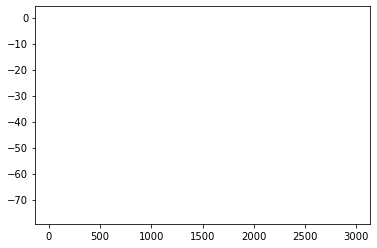

#### Run the MC 

In [150]:
for it in range(tot_it):
    update_run_model(varlist,it)
    print('Finished iteration ',it+1,'out of ',tot_it)


save_obj(m.MC_file.parent,varlist,'varlist_success')
save_obj(m.MC_file.parent, m.dis.get_node_coordinates(),'yxz')
print('Saved file ',m.MC_file.parent.joinpath('varlist_success.pkl'))
print('Saved file ',m.MC_file.parent.joinpath('yxz.pkl'))


Assigning hk = 26.122937099604314 

Assigning vka = 0.050108656076477645 

Assigning al = 3.0204422272605496 

Assigning dmcoef = 8.536916958038742e-10 

Assigning rech = 4.817340846312183e-08 

Assigning rech_farm = 6.236523689464485e-08 

Assigning wel = [ 25.63920173 570.47270882] 

Assigning riv_stg = 1.3007445686755368 

Assigning riv_cond = 0.871510320597814 

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Packag

TypeError: 'bool' object is not subscriptable

In [ ]:

it = 0
#insert new values
hk=varlist['rech_farm'][it]
vka=varlist['vka'][it]
al=varlist['al'][it]
dmcoef=varlist['dmcoef'][it]
riv_stg=varlist['riv_stg'][it]
riv_cond=varlist['riv_cond'][it]

ssm_data = {}
#write recharge data
rech_farm[farm_loc] = varlist['rech_farm'][it]
rech_data = {}
for i in range(len(perlen)):
    if i%2==0:
        rech_data[i] = np.ones((nrow,ncol),dtype=np.float)*varlist['rech'][it] 
    else:
        rech_data[i] = rech_farm 

#write well data
#write wel data
ssm_data_base = load_obj(m.MC_file.parent,'ssm_data_base')
wel_data_base = load_obj(m.MC_file.parent,'wel_data_base')
wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,
                                      flx=varlist['wel'][:,it],rowcol=farm_orig,kper=kper_odd)    

#Write river data--take SSM data from WEL!!
riv_grad = .0005
riv_data,ssm_data = write_river_data(riv_loc,riv_stg,riv_cond,riv_grad,kper_even,ssm_data)            

###### Reassign, run record ######
#Reassign to model object
#assign_m()
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='CHD' or bc_inland=='CHD':
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
if bc_ocean=='GHB' or bc_inland=='GHB' or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
rch = flopy.modflow.ModflowRch(m, rech=rech_data)
riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
flist = [os.path.join(model_ws,'MT3D.CNF'),
          os.path.join(model_ws,'MT3D001.MAS'),
          os.path.join(model_ws, modelname + '.hds'),
          os.path.join(model_ws, 'MT3D001.UCN'),
          os.path.join(model_ws, 'MT3D001.UCN'),
          os.path.join(model_ws, modelname + '.cbc')]
for f in flist:
    try:
        os.remove(f)
    except:
        pass

#Make timestamp
import datetime
sep = '-'
ts = datetime.datetime.now().strftime('%m'+sep+'%d'+sep+'%H'+sep+'%M'+sep+'%S')
ts_hms = ts.split(sep)[1:]
ts_hms = sep.join(ts_hms)



m.plot_hk_ibound(rowslice=0,printyn=False,gridon=True);

# #Run model
# v = m.run_model(silent=True, report=True)
# for idx in range(-3, 0): #Report
#     print(v[1][idx])

# #Record success/failure and store data
# if it==0:
#     varlist['success']= v[0]
# else:
#     varlist['success']= np.r_[varlist['success'],v[0]]

# if v[0] is False:  
#     continue
# else:
#     #Record final salinity as .npy, also move full CBC and UCN files to expt folder
#     fname = os.path.join(m.model_ws, 'MT3D001.UCN')
#     totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
#     conc_fname = 'conc{}_totim{}_{}.UCN'.format(it,str(int(totim)),ts_hms)
#     _ = record_salinity(m,ts_hms=ts_hms,fname_write=m.MC_file.parent.joinpath(conc_fname));
#     copy_rename(os.path.join(m.model_ws,'MT3D001.UCN'),
#                 m.MC_file.parent.joinpath(conc_fname).as_posix())
# print('Finished iteration ',it+1,'out of ',tot_it)



In [ ]:
m.check()

### Hausdorff (inactive)

In [10]:
varlist

{'hk': array([27.2894575 , 10.61515236]),
 'vka': array([0.57217935, 0.46355627]),
 'al': array([8.46531926, 6.67366294]),
 'dmcoef': array([1.05497743e-09, 1.24840308e-07]),
 'rech': array([1.57486515e-08, 1.07921104e-08]),
 'rech_farm': array([6.37733408e-07, 2.21146706e-07]),
 'wel': array([[ 18.58488554, 106.4525925 ],
        [ 23.38189637, 372.10910405],
        [510.4469172 ,  97.38087551],
        [493.31346615,  14.43081815]]),
 'riv_stg': array([1.00524609, 0.5652865 ]),
 'riv_cond': array([1.92471745, 0.1948017 ])}